In [1]:
import numpy as np
import torch
torch.manual_seed(0)
#from old_source_code.data import create_joint_x_y
from old_source_code.optimal_transport import estimate_entropy_dual_psi
from torch import nn

dataset_size = 7800
#X, Y = create_joint_x_y(dataset_size)

seed = 0
dataset_name = "taxi"
dataset_path = f"../data/{dataset_name}_seed_{seed}_samples.npz"

with np.load(dataset_path) as npzf:
    print(f"{npzf["X_train"].shape=}")
    X = npzf["X_train"][:dataset_size]
    Y = npzf["Y_train"][:dataset_size]
    X_raw = npzf["X_train_raw"][:dataset_size]
    X_test = npzf["X_test"][:dataset_size]
    Y_test = npzf["Y_test"][:dataset_size]

n, d = Y.shape
m = n

phi_network = nn.Sequential(
    nn.Linear(d + X.shape[1], 100),
    nn.Softplus(),
    nn.Linear(100, 100),
    nn.Softplus(),
    nn.Linear(100, 1)
)

device_and_dtype_specifications = dict(
    dtype=torch.float64,
    device=torch.device("cuda")
)

epsilon = 1e-7
num_epochs = 2000
batch_size = 512

phi_network.to(**device_and_dtype_specifications)
phi_network_optimizer = torch.optim.Adam([dict(params=phi_network.parameters())], lr=0.001)

X_tensor = torch.tensor(X, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)

npzf["X_train"].shape=(7800, 6)


In [2]:
#print(f"{X_raw[0, :]=}")

In [3]:
from tqdm.notebook import trange

training_information = []
progress_bar = trange(1, num_epochs+1, desc="Training")

for epoch_idx in progress_bar:
    phi_network.zero_grad()
    yindexes = torch.randint(0, dataset_size, (batch_size,))
    entropy_indexes = torch.randint(0, dataset_size, (256,))
    X_batch = X_tensor[yindexes]
    Y_batch = Y_tensor[yindexes]
    U_batch = torch.randn(
        batch_size, Y_batch.shape[1],
        **device_and_dtype_specifications
    )
    phi = phi_network(torch.cat([X_batch, U_batch], dim=1))
    psi = estimate_entropy_dual_psi(
        X_tensor=X_batch,
        U_tensor=torch.randn(
            2048, Y_batch.shape[1],
            **device_and_dtype_specifications
        ),
        Y_tensor=Y_batch,
        phi_net=phi_network,
        epsilon=epsilon
    )
    
    objective = torch.mean(phi) + torch.mean(psi)
    objective.backward()
    phi_network_optimizer.step()
    training_information.append({
        "objective": objective.item(),
        "epoch_index": epoch_idx,
        "epsilon": epoch_idx,
    })
    if epoch_idx % 10 == 0:
        running_mean_objective = sum([information["objective"] for information in training_information[-10:]]) / len(training_information[-10:])
        running_median_objective = np.median([information["objective"] for information in training_information[-10:]])
        progress_bar.set_description(f"Epoch: {epoch_idx}, epsilon: {epsilon}, objective: {running_mean_objective:.3f}, median: {running_median_objective:.3f}")

_ = phi_network.eval()


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

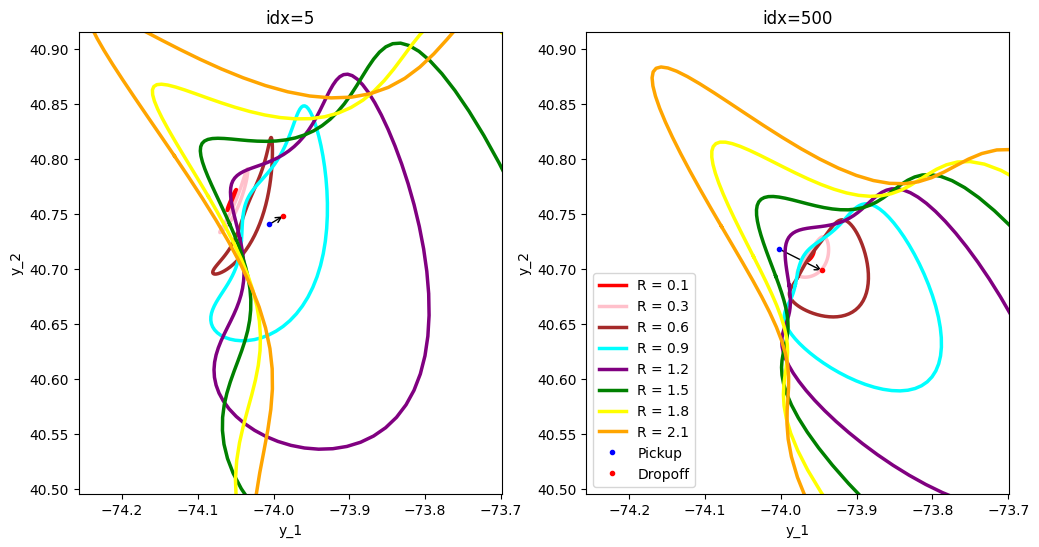

In [4]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
num_angles = 100

for ax, idx in zip ((ax1, ax2), (5, 500)):
    ax.set_title(f'{idx=}')
    ax.set_xlabel('y_1')
    ax.set_ylabel('y_2')
    x = X_tensor[idx:(idx + 1)]
    x = x.repeat(num_angles, 1)


    colors = ['red', 'pink', 'brown', 'cyan', 'purple', 'green', 'yellow', "orange"]
    radii = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 5]
    for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, num_angles)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True


        potential = phi_network(torch.cat([x, u_tensor], dim=1))
        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        ax.plot(pushforward_of_u[:, 0].numpy(force=True), pushforward_of_u[:, 1].numpy(force=True), 
                color=color, linewidth=2.5, label=f"R = {contour_radius}")

    ax.plot(X_raw[idx, -2], X_raw[idx, -1], 
            markersize=3, marker='o', linestyle='', color='blue', label='Pickup')
    ax.plot(Y[idx, 0], Y[idx, 1], 
            markersize=3, marker='o', linestyle='', color='red', label='Dropoff')
    con = ConnectionPatch(
        xyA=X_raw[idx, -2:], xyB=Y[idx, :], coordsA='data', coordsB='data',
        axesA=ax, axesB=ax,
        arrowstyle="->") #, shrinkB=5)
    ax.add_artist(con)

    ax.set_xlim(-74.257159, -73.699215)
    ax.set_ylim(40.495992, 40.915568)
plt.legend()
plt.show()


# Warning! Maps sometimes take to long to load or crash the kernel. To be updated.

In [ ]:
import cartopy.crs as ccrs
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import io
#from urllib.request import urlopen, Request
#from PIL import Image

In [23]:
osm_img = cimgt.OSM(desired_tile_form="L", cache=False)
extent = [-74.257159, -73.699215, 40.495992, 40.915568] # NYC bounds

%matplotlib inline

fig = plt.figure(figsize=(12, 9)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
ax1.set_extent(extent) # set extents
ax1.set_xticks(np.linspace(extent[0], extent[1], 7), crs=ccrs.PlateCarree()) # set longitude indicators
ax1.set_yticks(np.linspace(extent[2], extent[3], 7)[1:], crs=ccrs.PlateCarree()) # set latitude indicators
lon_formatter = LongitudeFormatter(number_format='0.1f', degree_symbol='', dateline_direction_label=True) # format lons
lat_formatter = LatitudeFormatter(number_format='0.1f', degree_symbol='') # format lats
ax1.xaxis.set_major_formatter(lon_formatter) # set lons
ax1.yaxis.set_major_formatter(lat_formatter) # set lats
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

scale = np.ceil(-np.sqrt(2)  *np.log(np.divide((extent[1] - extent[0]) / 2.0, 350.0))) # empirical solve for scale based on zoom
scale = (scale < 20) and scale or 19 # scale cannot be larger than 19
print(f"{scale=}")
#ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification

idx = 500
ax1.set_title(f'NY Taxi Map, {idx=}', fontsize=16)
x = X_tensor[idx:(idx + 1)]
x = x.repeat(num_angles, 1)


colors = ['red', 'pink', 'brown', 'cyan', 'purple', 'green', 'yellow', "orange"]
radii = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 5]
for contour_radius, color in zip(radii, colors):
    pi_tensor = torch.linspace(-torch.pi, torch.pi, num_angles)
    u_tensor = torch.stack([
        contour_radius * torch.cos(pi_tensor),
        contour_radius * torch.sin(pi_tensor),
    ], dim=1)

    u_tensor = u_tensor.to(**device_and_dtype_specifications)
    u_tensor.requires_grad = True


    potential = phi_network(torch.cat([x, u_tensor], dim=1))
    pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

    ax1.plot(pushforward_of_u[:, 0].numpy(force=True), pushforward_of_u[:, 1].numpy(force=True), 
             transform=ccrs.PlateCarree(), color=color, linewidth=2.5, label=f"R = {contour_radius}")
# Draw actual pickup and dropoff points
#ax1.plot([X_raw[idx, -2], Y[idx, 0]], [X_raw[idx, -1], Y[idx, 1]], transform=ccrs.PlateCarree(), 
#         color="black", linewidth=2.5, linestyle='--', label=f"Trip")
con = ConnectionPatch(xyA=X_raw[idx, -2:], xyB=Y[idx, :], coordsA='data', coordsB='data',
                      axesA=ax1, axesB=ax1,
                      arrowstyle="->") #, shrinkB=5)
ax1.add_artist(con)
ax1.plot(X_raw[idx, -2], X_raw[idx, -1], transform=ccrs.PlateCarree(), 
         markersize=10, marker='o', linestyle='', color='blue', label='Pickup')
ax1.plot(Y[idx, 0], Y[idx, 1], transform=ccrs.PlateCarree(), 
         markersize=10, marker='o', linestyle='', color='red', label='Dropoff')
plt.legend()
plt.show()


: 

/home/alex/repos/conditional_quantile_function/.venv/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


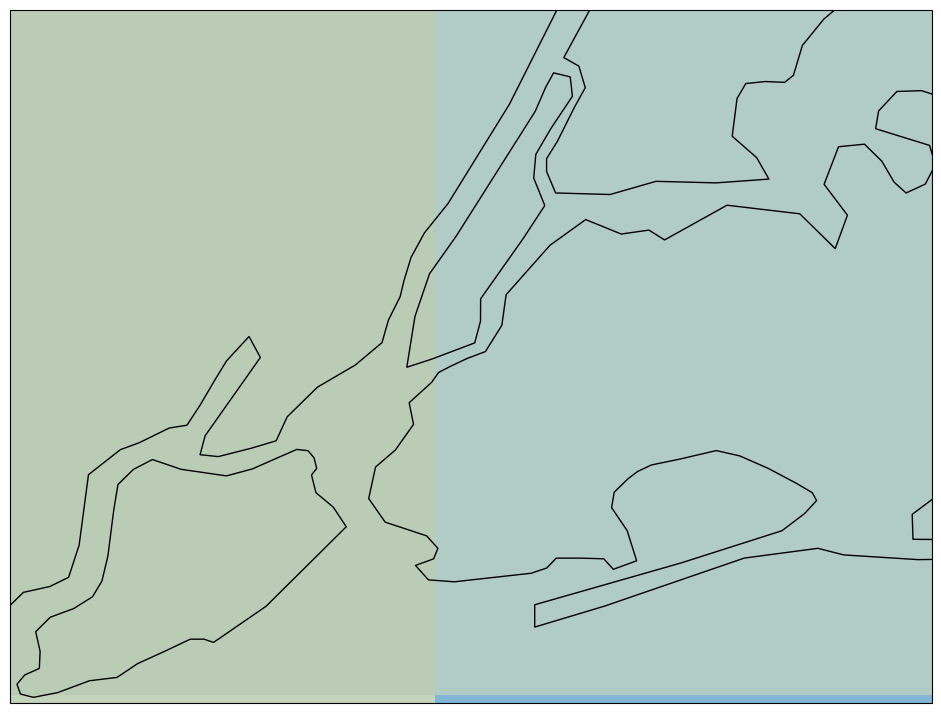

In [19]:
%matplotlib inline

import cartopy.crs as ccrs

extent = [-74.257159, -73.699215, 40.495992, 40.915568] # NYC bounds

fig = plt.figure(figsize=(12, 9)) # open matplotlib figure
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.coastlines()
ax.stock_img()

plt.show()